In [1]:
import numpy as np
import lasagne
import time
from nbfinder import NotebookFinder
import sys
sys.meta_path.append(NotebookFinder())
from matplotlib import pyplot as plt
import json
import pickle
%matplotlib inline
from matplotlib import patches
from helper_fxns import early_stop
import logging
from data_loader import load_classification_dataset, load_detection_dataset
from print_n_plot import print_train_results,plot_learn_curve,print_val_results, plot_ims_with_boxes

importing Jupyter notebook from helper_fxns.ipynb
importing Jupyter notebook from data_loader.ipynb
importing Jupyter notebook from print_n_plot.ipynb


In [5]:

    
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    if batchsize > inputs.shape[0]:
        batchsize=inputs.shape[0]
    for start_idx in range(0,len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx: start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def train_one_epoch(x,y,batchsize, train_fn, val_fn):
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(x, y, batchsize, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        _, acc = val_fn(inputs, targets)
        train_acc += acc
        train_batches += 1
    return train_err, train_acc, train_batches

def val_one_epoch(x, y, batchsize, val_fn):
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(x,y, batchsize, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1
        return val_err, val_acc, val_batches
def do_one_epoch(epoch,num_epochs, x_train, y_train, x_val, y_val, batchsize, train_fn, val_fn,
                 train_errs, train_accs, val_errs, val_accs, val_counter, logging):
        start_time = time.time()
        tr_err, tr_acc, tr_batches = train_one_epoch(x_train, y_train,
                                                     batchsize=batchsize,
                                                     train_fn=train_fn,
                                                     val_fn=val_fn)
                
        train_errs.append(tr_err / tr_batches)
        train_accs.append(tr_acc / tr_batches)
        print_train_results(epoch, num_epochs, start_time, tr_err / tr_batches, tr_acc / tr_batches, logging)
        
        
        if epoch % 50 == 0:
            val_err, val_acc, val_batches = val_one_epoch(x_val, y_val,
                                                         batchsize=y_val.shape[0],
                                                          val_fn=val_fn)

            val_counter.append(epoch)
            val_errs.append(val_err / val_batches)
            val_accs.append(val_acc / val_batches)
            print_val_results(val_err, val_acc / val_batches, logging)
        

def setup_logging(save_path):
    logger = logging.getLogger('simple_example')
    logger.setLevel(logging.DEBUG)
    # create file handler which logs even debug messages
    fh = logging.FileHandler('%s/training.log'%(save_path))
    fh.setLevel(logging.DEBUG)
    # create console handler with a higher log level
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    logger.addHandler(ch)
    logger.addHandler(fh)
    return logger
    

def train(datasets, network,
          fns, 
          num_epochs, 

          save_weights=False, 
          save_plots=True, 
          save_path='./results', 
          batchsize=128, 
          load_path=None):
    
    
    logger = setup_logging(save_path)


    
    
    train_fn, val_fn, box_fn = fns

        
    #todo add in detect
    x_tr, y_tr,x_val, y_val, x_te, y_te = datasets
    
    if batchsize is None or x_tr.shape[0] < batchsize:
        batchsize = x_tr.shape[0]
    
    
    #pick 6 random images to look at
    inds = np.random.randint(low=0, high=x_tr.shape[0], size=(6,))
    
    print "Starting training..." 
    train_errs, train_accs, val_errs, val_accs, val_counter = [], [], [], [], []
    for epoch in range(num_epochs):
        do_one_epoch(epoch,num_epochs, x_tr, y_tr, x_val, y_val,batchsize, train_fn, val_fn,
                     train_errs, train_accs, val_errs, val_accs,val_counter, logger)
        

        
        if epoch % 10 == 0 and epoch !=0:
            plot_learn_curve(train_errs,val_errs,val_counter, 'err', save_plots=save_plots,path=save_path)
            plot_learn_curve(train_accs,val_accs,val_counter, 'acc', save_plots=save_plots, path=save_path)

            if epoch % 100 == 0:
                pred_boxes, gt_boxes = box_fn(x_tr,y_tr)              
                plot_ims_with_boxes(x_tr[inds], pred_boxes[inds], gt_boxes[inds], epoch=epoch,
                                    save_plots=save_plots, path=save_path)

            
            
            
            
        


        if save_weights and epoch % 10 == 0:
  
            np.savez('%s/model.npz'%(save_path), *lasagne.layers.get_all_param_values(network))


In [ ]:
inds = np.random.randint

In [ ]:
inds = np.random.randint

getting data...
40
running on non pretrained classif network!
Building model and compiling functions...
Building model and compiling functions...
Starting training...
Epoch 1 of 20 took 2.783s
	training los:		7.5409
	training acc:		0.0000 %
  validation loss:		9.373669
  validation accuracy:		0.00 %


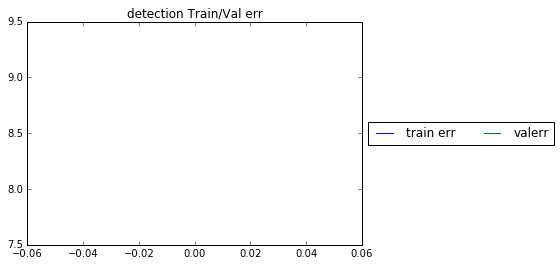

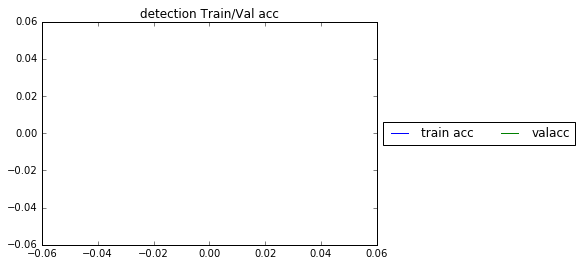

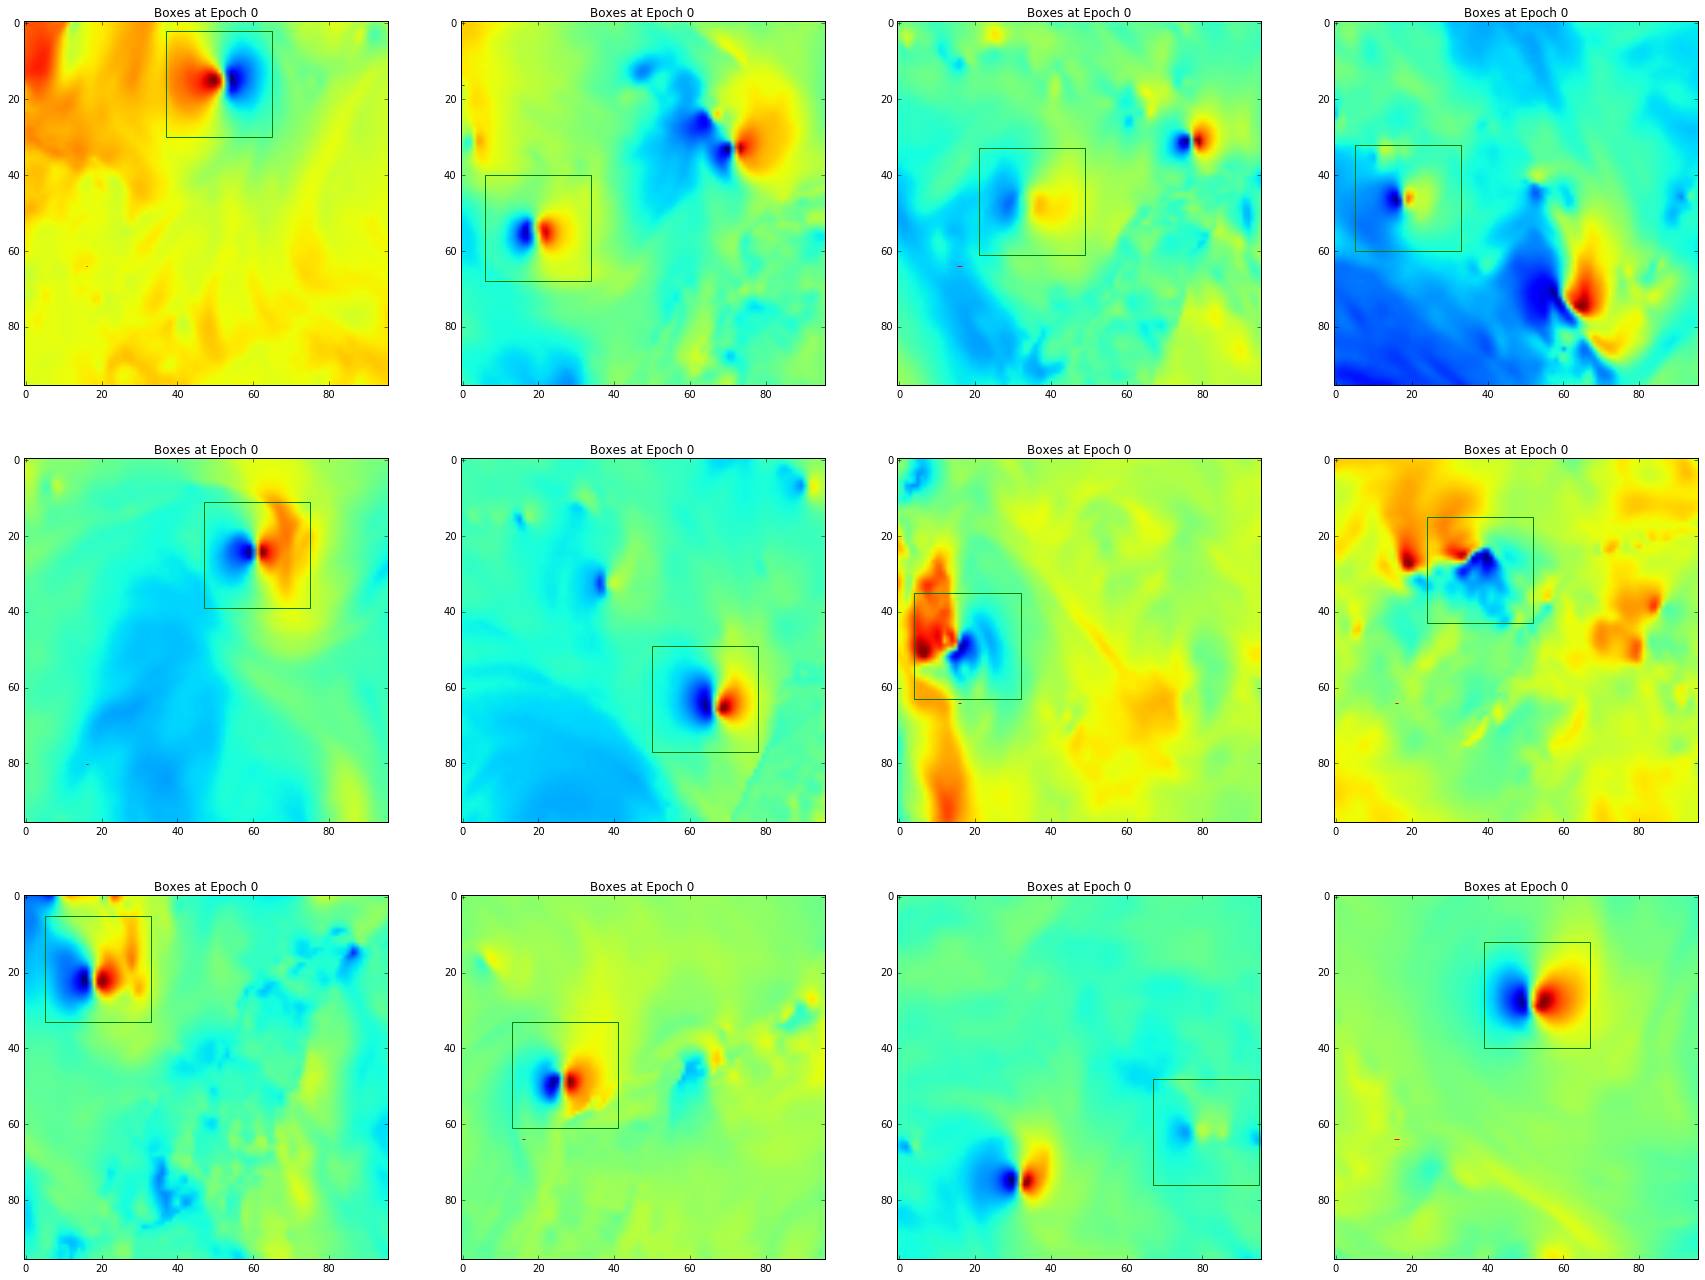

Epoch 2 of 20 took 2.233s
	training los:		6.8375
	training acc:		0.0000 %
  validation loss:		9.088693
  validation accuracy:		0.00 %
Epoch 3 of 20 took 2.042s
	training los:		6.5959
	training acc:		0.0000 %
  validation loss:		8.844414
  validation accuracy:		0.00 %
Epoch 4 of 20 took 1.971s
	training los:		6.2405
	training acc:		0.0000 %
  validation loss:		8.772713
  validation accuracy:		0.00 %


KeyboardInterrupt: 

In [6]:

if __name__=="__main__":
    dataset = load_detection_dataset(num_ims=40, with_boxes=True)
    n = train(dataset,num_epochs=20, mode='detection',batchsize=24, network_kwargs={'num_filters':10,'num_fc_units':128, 'learning_rate': 0.001})


